# Logistic Regression with Python

We will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
titanic_train = pd.read_csv('titanic_train.csv')
train = titanic_train.copy()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<Axes: >

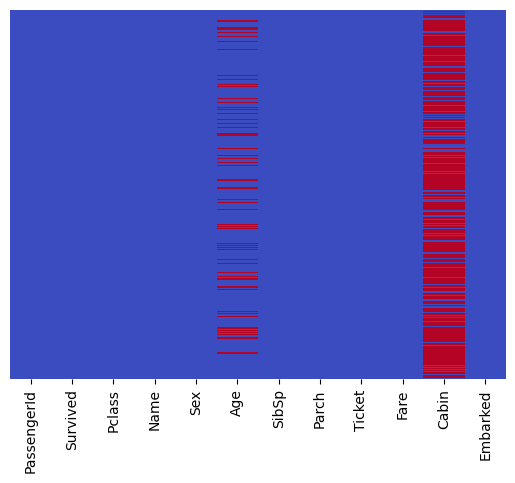

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')


Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data!

<Axes: xlabel='Survived', ylabel='count'>

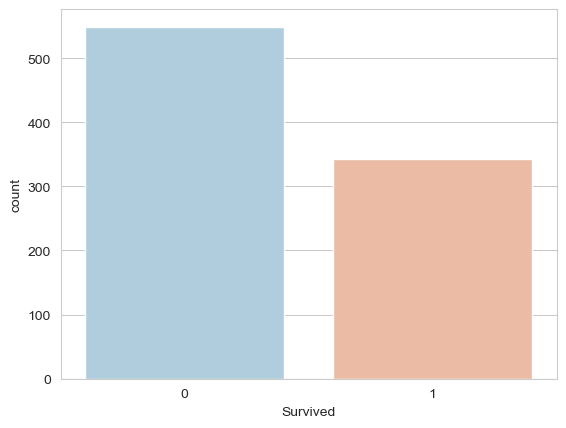

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

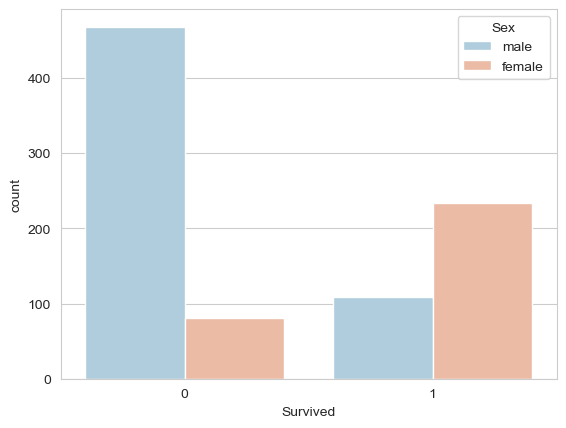

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

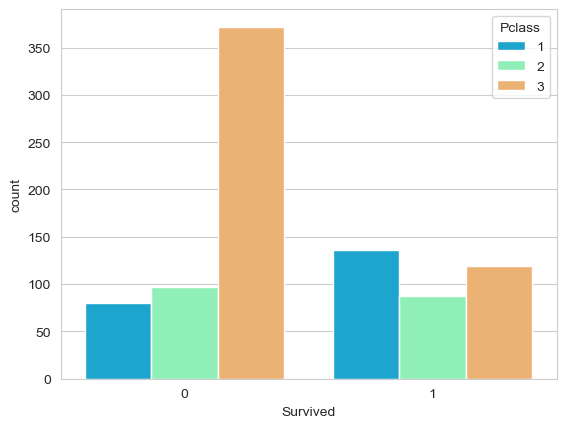

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: xlabel='Age', ylabel='Count'>

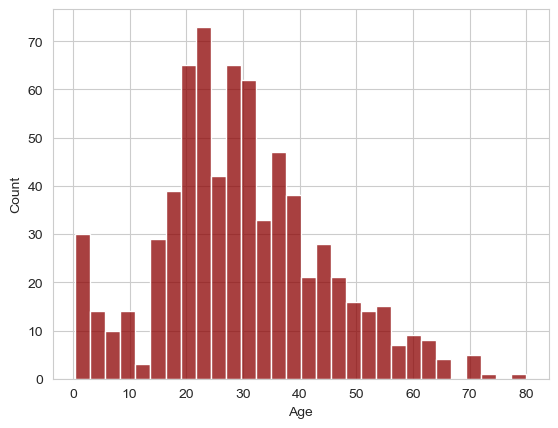

In [8]:
sns.histplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<Axes: xlabel='SibSp', ylabel='count'>

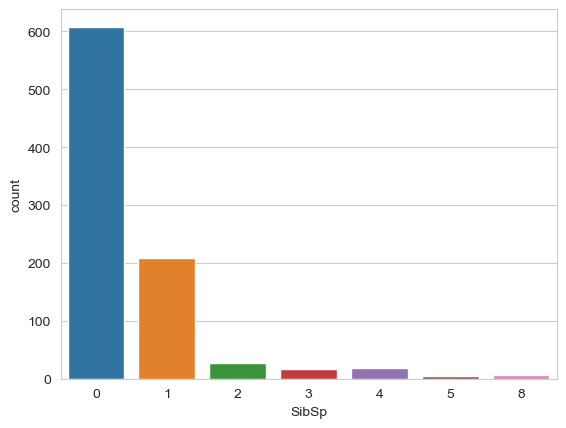

In [9]:
sns.countplot(x='SibSp',data=train)

<Axes: >

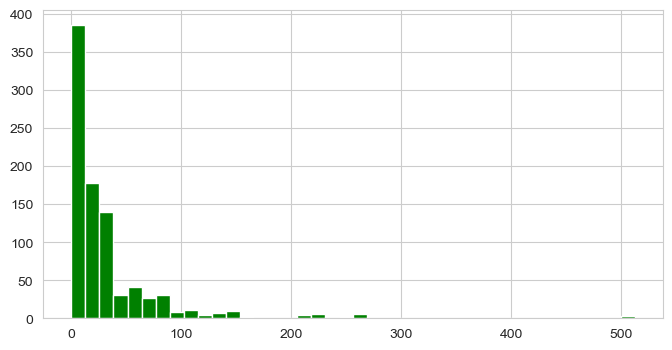

In [10]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

<Axes: xlabel='Pclass', ylabel='Age'>

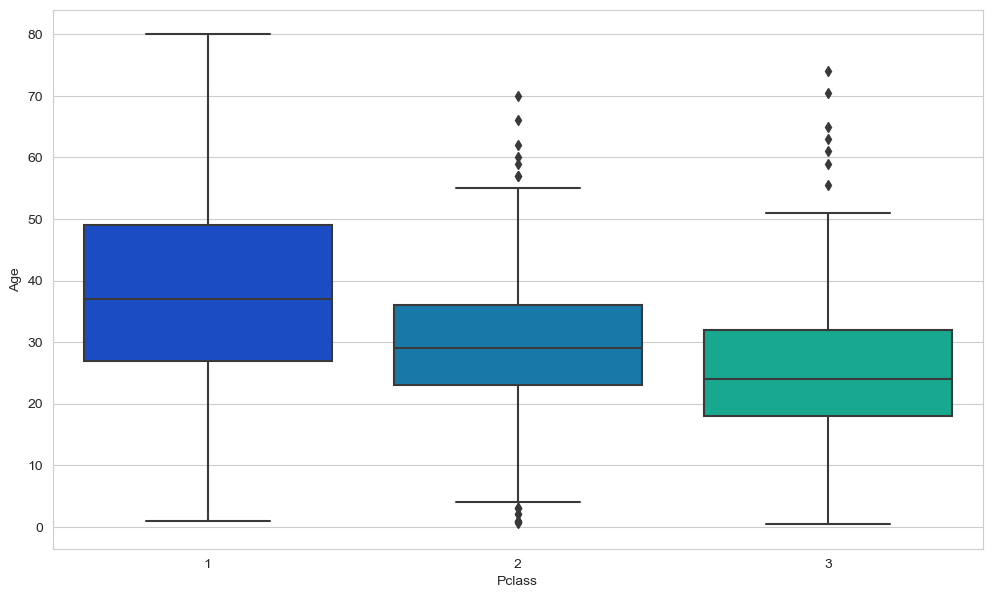

In [11]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [12]:
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [13]:
train.groupby('Pclass')['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [14]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [15]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<Axes: >

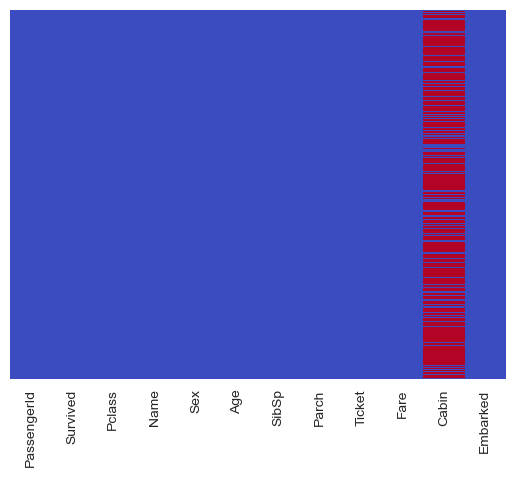

In [16]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [17]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [19]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

X = train.drop('Survived',axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Training and Predicting

In [25]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel.coef_
logmodel.intercept_
cdf = pd.DataFrame(logmodel.coef_.reshape((9,1)), X_train.columns, columns=['Coefficients'])
cdf.loc['INTERCEPT'] = logmodel.intercept_
cdf

/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Coefficients
PassengerId,0.000305
Pclass,-0.886028
Age,-0.029015
SibSp,-0.331649
Parch,-0.039274
Fare,0.004763
male,-2.503254
Q,-0.028376
S,0.390151
INTERCEPT,3.433609


In [29]:
print(logmodel.predict_proba(X_test))
predictions = logmodel.predict(X_test)
predictions

[[0.86288476 0.13711524]
 [0.90276307 0.09723693]
 [0.19114179 0.80885821]
 [0.10893288 0.89106712]
 [0.89654148 0.10345852]
 [0.94598266 0.05401734]
 [0.81945194 0.18054806]
 [0.75626419 0.24373581]
 [0.8935204  0.1064796 ]
 [0.53325942 0.46674058]
 [0.18674815 0.81325185]
 [0.10087659 0.89912341]
 [0.85765823 0.14234177]
 [0.5364167  0.4635833 ]
 [0.8486025  0.1513975 ]
 [0.84356434 0.15643566]
 [0.06595258 0.93404742]
 [0.23622685 0.76377315]
 [0.43615819 0.56384181]
 [0.87923248 0.12076752]
 [0.87481205 0.12518795]
 [0.8929037  0.1070963 ]
 [0.58521051 0.41478949]
 [0.65649155 0.34350845]
 [0.95098745 0.04901255]
 [0.55145659 0.44854341]
 [0.55776495 0.44223505]
 [0.56899854 0.43100146]
 [0.9110889  0.0889111 ]
 [0.70680968 0.29319032]
 [0.89470139 0.10529861]
 [0.55448421 0.44551579]
 [0.98707121 0.01292879]
 [0.88114757 0.11885243]
 [0.86308872 0.13691128]
 [0.91788749 0.08211251]
 [0.22554715 0.77445285]
 [0.90939795 0.09060205]
 [0.95417821 0.04582179]
 [0.83473956 0.16526044]


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

NOTA: 

* Un modelo de regresión logística trabaja prácticamente como un modelo de regresión lineal, es decir, se obtienen los coeficientes e intercepto a través de una regresión lineal multiple, para luego usarlos en la funcion OSigmoide que es la funcion característica de la regresión logística y así obtener valores de probabilidades, es decir, entre 0 y 1.

* El resultado de la función logística se almacena en **logmodel.predict_proba(X_test)** en la posición 1, y en la posición 0 se almacena simplemente la diferencia con respecto a 1, para luego decir: el valor de la posicion 1 es mayor que 0.5 pues toma valor 1 (Sobrevivió), es menor que 0.5 pues toma valor 0(No Sobrevivió) y queda reflejado en **logmodel.predict(X_test)**

---
NOTE:

* A logistic regression model works much like a linear regression model, that is, coefficients and intercept are obtained through multiple linear regression, and then used in the Sigmoid function, which is the characteristic function of logistic regression, to obtain probability values, between 0 and 1.

* The result of the logistic function is stored in **logmodel.predict_proba(X_test)** at position 1, and at position 0, it simply stores the difference with respect to 1. Then, if the value at position 1 is greater than 0.5, it is assigned a value of 1 (Survived). If it is less than 0.5, it is assigned a value of 0 (Did Not Survive), which is reflected in **logmodel.predict(X_test).**

---
Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.81      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267



En resumen, el modelo parece tener un rendimiento general decente, con una precisión global del 80%. Sin embargo, muestra una capacidad mejor para identificar correctamente la clase 0 (No Sobrevivió) en comparación con la clase 1 (Sobrevivió), como lo indican las métricas más altas de precisión y recall para la clase 0, ya que un recall de 0.91 para la clase 0 significa que el modelo pudo identificar correctamente el 91% de todas las instancias reales de la clase 0, pero para la clase 1, el recall es de 0.62, indicando que solo pudo identificar correctamente el 62% de todas las instancias reales de la clase 1.

---
The model appears to have a decent overall performance, with an overall accuracy of 80%. However, it shows a better ability to correctly identify class 0 (Did Not Survive) compared to class 1 (Survived), as indicated by the higher precision and recall metrics for class 0. A recall of 0.91 for class 0 means that the model was able to correctly identify 91% of all the actual instances of class 0, but for class 1, the recall is 0.62, indicating that it was only able to correctly identify 62% of all the actual instances of class 1.